# Time Series Classification

Time Series Classification (TSC) involves training a model from a collection
 of time series (real valued, ordered, data) in order to predict a target variable.
 For example, we might want to build a model that can predict whether a patient
 is sick based on their ECG reading, or a persons type of movement based on the trace
  of the position of their hand. This notebook gives a quick guide to TSC to get you
  started using aeon time series classifiers. If you can use scikit-learn, it should
   be easy, because the basic usage is identical.

<img src="img/tsc.png" width="600" alt="time series classification">

## Data Storage and Problem Types

Time series can be univariate (each observation is a single value) or multivariate
(each observation is a vector). For example, an ECG reading from a single
sensor is a univariate series, but a motion trace of from a smart watch would be
multivariate, with at least three dimensions (x,y,z co-ordinates). The image above is
 a univariate problem: each series has its own label. The dimension of the time
 series instance is also often called the channel. We recommend storing time series
 in 3D numpy array of shape `(n_instances, n_channels, n_timepoints)` and
 where  possible our single problem loaders will return a
 3D numpy. Unequal length classification problems are stored in a list of 2D numpy
 arrays.

In [1]:
# Plotting and data loading imports used in this notebook
import warnings

import matplotlib.pyplot as plt

from aeon.datasets import load_arrow_head

warnings.filterwarnings("ignore")

arrow, arrow_labels = load_arrow_head(split="train")
print(f"ArrowHead series of type {type(arrow)} and shape {arrow.shape}")

ArrowHead series of type <class 'numpy.ndarray'> and shape (36, 1, 251)


We tend to use 3D numpy even if the data is univariate, although all classifiers work
 with shape (instance, time point), currently some transformers do not work correctly
  with 2D arrays. If your series are unequal length, have missing values or are
  sampled at irregular time intervals, you should read the note book
  on [data preprocessing](../utils/preprocessing.ipynb).

The UCR/UEA [TSC dataset archive](https://timeseriesclassification.com/) contains a
large number of example TSC problems that have been used thousands of times in the
literature to assess TSC algorithms. These datasets have certain characteristics that
influence what data structure we use to store them in memory.

Most datasets in the archive contain time series all the same length. For example,
the [ArrowHead dataset](https://timeseriesclassification.com/description.php?Dataset=ArrowHead) we have just loaded consists of outlines of the images of
arrow heads. The classification of projectile points is an important topic in anthropology.

<img src="../img/arrow-heads.png" width="600" alt="arrow heads">

The shapes of the projectile points are converted into a sequence using the
angle-based method as described in this [blog post](https://izbicki.me/blog/converting-images-into-time-series-for-data-mining.html) about converting images into time series for data mining.

<img src="img/from-shapes-to-time-series.png" width="600" alt="from shapes to time series">

Each instance consists of a single time series (i.e. the problem is univariate) of
equal length and a class label based on shape distinctions such as the presence and
location of a notch in the arrow. The data set consists of 210 instances, by default split into 36 train and 175 test instances.


['0' '1' '2'] [12 12 12]


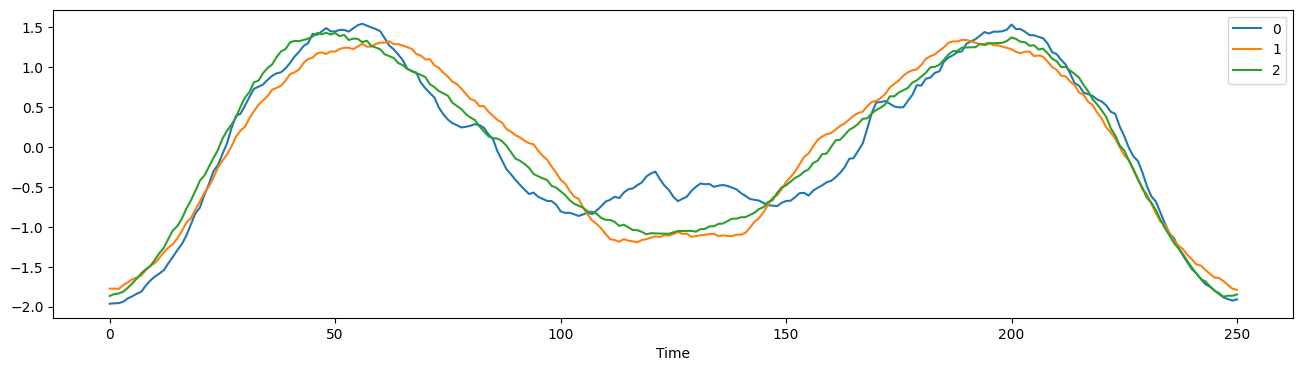

In [2]:
import numpy as np

labels, counts = np.unique(arrow_labels, return_counts=True)
print(labels, counts)

def select_series(X, y, label): 
    return X[np.where(y == label)[0][0], 0, :]

fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
for label in labels:
    ax.plot(select_series(arrow, arrow_labels, label), label=label)
ax.set(xlabel="Time")
ax.legend();

## Why not use sklearn?

It is possible to use a standard `sklearn` classifier for univariate, equal length
classification problems, but it is unlikely to perform as well as bespoke time series
 classifiers, since `sklearn` classifiers ignore the sequence information in the variables.

### Treating each time point as a separate feature

To apply `sklearn` classifiers directly, the data needs to be reshaped into a 2D
numpy array. We also offer the ability to load univariate TSC problems directly in 2D
 arrays. Please note that currently,
 some Transformers treat a single multivariate time series in a numpy array as shape
 `(n_timepoints, n_channels)` rather than `(n_channels,n_timepoints)`
  do not work correctly  with 2D numpy classification problems, so we recommend using
   3D numpyof shape `(n_channels, 1, n_timepoints)` for univariate series.

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rand_forest = RandomForestClassifier(n_estimators=100)
arrow2d = arrow.squeeze()
arrow_test, arrow_test_labels = load_arrow_head(split="test", return_type="numpy2d")
rand_forest.fit(arrow2d, arrow_labels)
y_pred = rand_forest.predict(arrow_test)
accuracy_score(arrow_test_labels, y_pred)

0.6857142857142857

What's the implicit modelling choice here?

> We treat each observation as a separate feature and thus ignore they are ordered in time. A tabular algorithm cannot make use of the fact that features are ordered in time, i.e. if we changed the order of the features, the fitted model and predictions wouldn't change. While this may work well in some cases, usually specialized time series classifiers perform better. 

### Feature extraction

Another modelling choice: we could extract features from the time series and then use the features to fit our tabular classifier. Here we use [tsfresh](https://tsfresh.readthedocs.io) for automatic feature extraction.

See feature extraction notebook. 

## Dedicated time Series classifiers

`aeon` contains the state of the art in time series classifiers in the package
`classification`. These are grouped based on the data representation used to find
discriminatory features. We provide a separate notebook for each of type:
[convolution based](convolution_based.ipynb), [deep learning](deep_learning.ipynb), [distance based](distance_based.ipynb), [dictionary based](dictionary_based.ipynb),
[feature_based](feature_based.ipynb), [hybrid](hybrid.ipynb), [interval based](interval_based.ipynb), and [shapelet based](shapelet_based.ipynb). We also
provide some
standard classifiers not available in scikit learn in the sklearn package.
We show the simplest use cases for classifiers and demonstrate how to build bespoke
pipelines for time series classification. An accurate and relatively
fast classifier is the [ROCKET](https://link.springer.com/article/10.1007/s10618-020-00701-z) classifier. ROCKET is a convolution based algorithm
described in detail in the [convolution based](convolution_based.ipynb) note book.

In [4]:
from aeon.classification.convolution_based import RocketClassifier

rocket = RocketClassifier(num_kernels=1_000)
rocket.fit(arrow, arrow_labels)
y_pred = rocket.predict(arrow_test)

accuracy_score(arrow_test_labels, y_pred)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


0.8228571428571428

Another accurate classifier for time series classification is version 2 of the
[HIVE-COTE](https://link.springer.com/article/10.1007/s10994-021-06057-9) algorithm.
(HC2) is described in the [hybrid notebook](hybrid.ipynb) notebook. HC2 is relatively
slow
on small problems like these examples. However, it can be
configured with an approximate maximum run time as follows (it may take a bit longer
than 12 seconds to run this cell, very short times are approximate since there is a
minimum amount of work the classifier needs to do):

In [5]:
from aeon.classification.hybrid import HIVECOTEV2

hc2 = HIVECOTEV2(time_limit_in_minutes=0.2)
hc2.fit(arrow, arrow_labels)
y_pred = hc2.predict(arrow_test)

accuracy_score(arrow_test_labels, y_pred)

0.8171428571428572

In [6]:
from aeon.registry import all_estimators

all_estimators(
    estimator_types="classifier",
    as_dataframe=True,
)

,name,estimator
0,Arsenal,<class 'aeon.classification.convolution_based....
1,BOSSEnsemble,<class 'aeon.classification.dictionary_based._...
2,CNNClassifier,<class 'aeon.classification.deep_learning.cnn....
3,CanonicalIntervalForestClassifier,<class 'aeon.classification.interval_based._ci...
4,Catch22Classifier,<class 'aeon.classification.feature_based._cat...
5,ChannelEnsembleClassifier,<class 'aeon.classification.compose._channel_e...
6,ClassifierPipeline,<class 'aeon.classification.compose._pipeline....
7,ContractableBOSS,<class 'aeon.classification.dictionary_based._...
8,DrCIFClassifier,<class 'aeon.classification.interval_based._dr...
9,DummyClassifier,<class 'aeon.classification._dummy.DummyClassi...


## Multivariate Classification

The [BasicMotions dataset](https://timeseriesclassification.com/description.php?Dataset=BasicMotions) is an example of a multivariate TSC problem. It was generated
 as part of a project where four students performed four activities whilst wearing a
 smartwatch. The watch collects 3D accelerometer and 3D gyroscope data. Each instance
  involved a subject performing one of four tasks (walking, resting, running and
  badminton) for ten seconds. Time series in this data set have six dimensions or
  channels.

Motions type <class 'numpy.ndarray'> of shape (40,)


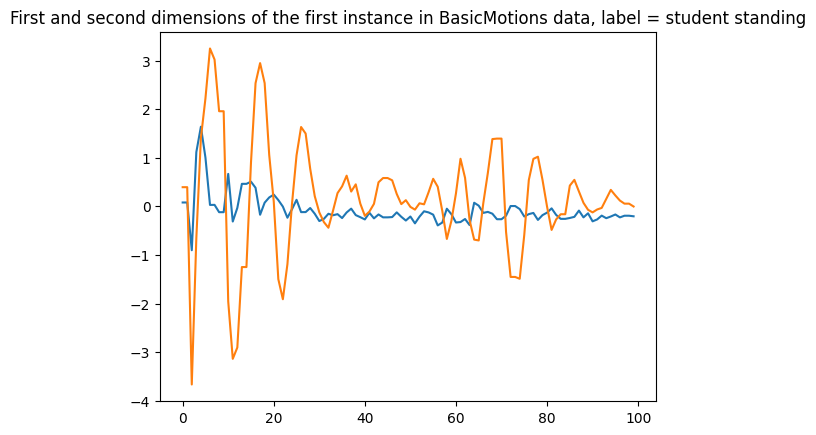

In [7]:
from aeon.datasets import load_basic_motions

motions, motions_labels = load_basic_motions(split="train")
print(f"Motions type {type(motions)} of shape {motions_labels.shape}")

plt.title(
    f"First and second dimensions of the first instance in BasicMotions data, "
    f"label = student {motions_labels[0]}"
)
plt.plot(motions[0][0])
plt.plot(motions[0][1])

To use ``sklearn`` classifiers directly on multivariate data, one option is to flatten
the data so that the 3D array `(n_cases, n_channels, series_length)` becomes a 2D array
of shape `(n_cases, n_channels*series_length)`.

In [8]:
motions_test, motions_test_labels = load_basic_motions(split="test")
motions2d = motions.reshape(motions.shape[0], motions.shape[1] * motions.shape[2])
motions2d_test = motions_test.reshape(
    motions_test.shape[0], motions_test.shape[1] * motions_test.shape[2]
)
rand_forest = RandomForestClassifier(n_estimators=100)
rand_forest.fit(motions2d, motions_labels)
y_pred = rand_forest.predict(motions2d_test)
accuracy_score(motions_test_labels, y_pred)

0.85

However, many ``aeon`` classifiers, including ROCKET and HC2, are configured to
work with multivariate input. This works exactly like univariate classification. For example:

In [9]:
rocket.fit(motions, motions_labels)
y_pred = rocket.predict(motions_test)
accuracy_score(motions_test_labels, y_pred)

1.0

A list of classifiers capable of handling multivariate classification can be obtained
 with this code

In [10]:
from aeon.registry import all_estimators

all_estimators(
    filter_tags={"capability:multivariate": True},
    estimator_types="classifier",
    as_dataframe=True,
)

,name,estimator
0,Arsenal,<class 'aeon.classification.convolution_based....
1,CNNClassifier,<class 'aeon.classification.deep_learning.cnn....
2,CanonicalIntervalForestClassifier,<class 'aeon.classification.interval_based._ci...
3,Catch22Classifier,<class 'aeon.classification.feature_based._cat...
4,ChannelEnsembleClassifier,<class 'aeon.classification.compose._channel_e...
5,DrCIFClassifier,<class 'aeon.classification.interval_based._dr...
6,DummyClassifier,<class 'aeon.classification._dummy.DummyClassi...
7,ElasticEnsemble,<class 'aeon.classification.distance_based._el...
8,EncoderClassifier,<class 'aeon.classification.deep_learning.enco...
9,FCNClassifier,<class 'aeon.classification.deep_learning.fcn....


An alternative for MTSC is to build a univariate classifier on each dimension, then
ensemble. Dimension ensembling can be easily done via ``ChannelEnsembleClassifier``
which fits classifiers independently to specified dimensions, then
combines predictions through a voting scheme. The interface is
similar to the ``ColumnTransformer`` from `sklearn`. The example below builds a DrCIF
classifier on the first channel and a RocketClassifier on the fourth and fifth
dimensions, ignoring the second, third and sixth.

In [11]:
from aeon.classification.compose import ChannelEnsembleClassifier
from aeon.classification.interval_based import DrCIFClassifier

cls = ChannelEnsembleClassifier(
    estimators=[
        ("DrCIF0", DrCIFClassifier(n_estimators=5, n_intervals=2), [0]),
        ("ROCKET3", RocketClassifier(num_kernels=1000), [3, 4]),
    ]
)

cls.fit(motions, motions_labels)
y_pred = cls.predict(motions_test)

accuracy_score(motions_test_labels, y_pred)

0.925

## sklearn Compatibility

`aeon` classifiers are compatible with `sklearn` model selection and
composition tools using `aeon` data formats. For example, cross-validation can
be performed using the `sklearn` `cross_val_score` and `KFold` functionality:

In [12]:
from sklearn.model_selection import KFold, cross_val_score

cross_val_score(rocket, arrow, y=arrow_labels, cv=KFold(n_splits=4))

array([0.88888889, 0.88888889, 0.88888889, 0.77777778])

Parameter tuning can be done using `sklearn` `GridSearchCV`. For example, we can tune
 the _k_ and distance measure for a K-NN classifier:

In [13]:
from sklearn.model_selection import GridSearchCV

from aeon.classification.distance_based import KNeighborsTimeSeriesClassifier

knn = KNeighborsTimeSeriesClassifier()
param_grid = {"n_neighbors": [1, 5], "distance": ["euclidean", "dtw"]}
parameter_tuning_method = GridSearchCV(knn, param_grid, cv=KFold(n_splits=4))

parameter_tuning_method.fit(arrow, arrow_labels)
y_pred = parameter_tuning_method.predict(arrow_test)

accuracy_score(arrow_test_labels, y_pred)

0.8

Probability calibration is possible with the `sklearn` `CalibratedClassifierCV`:

In [14]:
from sklearn.calibration import CalibratedClassifierCV

from aeon.classification.interval_based import DrCIFClassifier

calibrated_drcif = CalibratedClassifierCV(
    estimator=DrCIFClassifier(n_estimators=10, n_intervals=5), cv=4
)

calibrated_drcif.fit(arrow, arrow_labels)
y_pred = calibrated_drcif.predict(arrow_test)

accuracy_score(arrow_test_labels, y_pred)

0.7314285714285714

### Background info and references for classifiers used here

#### KNeighborsTimeSeriesClassifier

One nearest neighbour (1-NN) classification with Dynamic Time Warping (DTW) is one of the oldest TSC approaches, and is commonly used as a performance benchmark.

#### RocketClassifier
The RocketClassifier is based on a pipeline combination of the ROCKET transformation (transformations.panel.rocket) and the sklearn RidgeClassifierCV classifier. The RocketClassifier is configurable to use variants MiniRocket and MultiRocket. ROCKET is based on generating random convolutional kernels. A large number are generated, then a linear classifier is built on the output.

[1] Dempster, Angus, François Petitjean, and Geoffrey I. Webb. "Rocket: exceptionally fast and accurate time series classification using random convolutional kernels." Data Mining and Knowledge Discovery (2020)
[arXiv version](https://arxiv.org/abs/1910.13051)
[DAMI 2020](https://link.springer.com/article/10.1007/s10618-020-00701-z)

#### DrCIF
The Diverse Representation Canonical Interval Forest Classifier (DrCIF) is an interval based classifier. The algorithm takes multiple randomised intervals from each series and extracts a range of features. These features are used to build a decision tree, which in turn are ensembled into a decision tree forest, in the style of a random forest.

Original CIF classifier:
[2] Matthew Middlehurst and James Large and Anthony Bagnall. "The Canonical Interval Forest (CIF) Classifier for Time Series Classification." IEEE International Conference on Big Data (2020)
[arXiv version](https://arxiv.org/abs/2008.09172)
[IEEE BigData (2020)](https://ieeexplore.ieee.org/abstract/document/9378424?casa_token=8g_IG5MLJZ4AAAAA:ItxW0bY4eCRwfdV9kLvf-8a8X73UFCYUGU9D19PwrHigjivLJVchxHwkM3Btn7vvlOJ_0HiLRa3LCA)

The DrCIF adjustment was proposed in [3].

#### HIVE-COTE 2.0 (HC2)
The HIerarchical VotE Collective of Transformation-based Ensembles is a meta ensemble that combines classifiers built on different representations. Version 2  combines DrCIF, TDE, an ensemble of RocketClassifiers called the Arsenal and the  ShapeletTransformClassifier. It is one of the most accurate classifiers on the UCR and UEA time series archives.

[3] Middlehurst, Matthew, James Large, Michael Flynn, Jason Lines, Aaron Bostrom, and Anthony Bagnall. "HIVE-COTE 2.0: a new meta ensemble for time series classification." Machine Learning (2021)
[ML 2021](https://link.springer.com/article/10.1007/s10994-021-06057-9)

#### Catch22

The CAnonical Time-series CHaracteristics (Catch22) are a set of 22 informative and low redundancy features extracted from time series data. The features were filtered from 4791 features in the `hctsa` toolkit.

[4] Lubba, Carl H., Sarab S. Sethi, Philip Knaute, Simon R. Schultz, Ben D. Fulcher, and Nick S. Jones. "catch22: Canonical time-series characteristics." Data Mining and Knowledge Discovery (2019)
[DAMI 2019](https://link.springer.com/article/10.1007/s10618-019-00647-x)